# FOREST COVER CLASSIFICATION

First import needed modules 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



import the data, split into training and test sets and scale features

In [2]:
df = pd.read_csv("cover_data.csv")
feature = df.iloc[:, : -1]
labels = df.iloc[:, -1]
features_train, features_test, labels_train, labels_test = train_test_split(
    feature, 
    labels, 
    test_size = 0.2,
    random_state = 42,
    stratify = labels
)
scaler = StandardScaler()

features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [3]:
print(labels)
print(feature.columns)

0         5
1         5
2         2
3         2
4         5
         ..
581007    3
581008    3
581009    3
581010    3
581011    3
Name: class, Length: 581012, dtype: int64
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Typ

define functions to enable reusage especially when the need for tuning parameters arises during training and modeling

model design function

In [4]:
def design_model(learning_rate):

    model = Sequential()
    # Set the input layer:
    model.add(InputLayer(input_shape = (features_train_scaled.shape[1],)))
    
    # Set the hidden layers:
    model.add(Dense(256, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    #model.add(Dropout(0.1))
    model.add(Dense(64, activation = "relu"))
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(16, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    # Set the output layer:
    model.add(Dense(8, activation = "softmax"))
    opt = Adam(learning_rate = learning_rate)
    model.compile(
        loss = "sparse_categorical_crossentropy",  
        metrics = ["accuracy"], 
        optimizer = opt
    )

    model.summary()
    return model

def fit_model(learning_rate, num_epochs, batch_size):
    model = design_model(learning_rate)
    stop = EarlyStopping(
        monitor = "val_accuracy", 
        mode = "auto",
        verbose = 1, 
        patience = 10 
    )
    history = model.fit(
        features_train,
        labels_train,
        epochs = num_epochs,
        batch_size = batch_size,
        verbose = 1,
        validation_split = 0.1,        #  10% of the data would be allocated for validation
        callbacks = [stop]
    )
    return history, features_test, labels_test

plotting and visualization function

In [5]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_accuracy(history):
    # Plot accuracy
    fig = plt.figure(figsize = (15,10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='upper left')
    
    # Plot loss and val_loss over each epoch
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('plot learning curves')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper left') 
    fig.tight_layout()

def plot_heatmap(class_names, y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    #heatmapfig.savefig(f'../output/confusion_matrix.png')

report function

In [6]:
from sklearn.metrics import classification_report
import numpy as np

class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']

def report(model, features_test, labels_test):
    score = model.evaluate(features_test, labels_test, verbose = 0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    # evaluating the model:
    y_pred = model.predict(features_test)
    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    print(classification_report(labels_test, y_pred, target_names = class_names))

    return y_pred

run the model and visualize by setting parrameters to get the optimum result

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               14080     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 7

409/409 [==============================] - 10s 25ms/step - loss: 0.4580 - accuracy: 0.8108 - val_loss: 0.4606 - val_accuracy: 0.8071
Epoch 105/200
409/409 [==============================] - 10s 25ms/step - loss: 0.4555 - accuracy: 0.8114 - val_loss: 0.4760 - val_accuracy: 0.8014
Epoch 106/200
409/409 [==============================] - 10s 25ms/step - loss: 0.4561 - accuracy: 0.8121 - val_loss: 0.4572 - val_accuracy: 0.8077
Epoch 107/200
409/409 [==============================] - 10s 25ms/step - loss: 0.4564 - accuracy: 0.8110 - val_loss: 0.4665 - val_accuracy: 0.8024
Epoch 108/200
409/409 [==============================] - 10s 25ms/step - loss: 0.4549 - accuracy: 0.8124 - val_loss: 0.4641 - val_accuracy: 0.8054
Epoch 109/200
409/409 [==============================] - 10s 25ms/step - loss: 0.4529 - accuracy: 0.8130 - val_loss: 0.4563 - val_accuracy: 0.8100
Epoch 110/200
409/409 [==============================] - 10s 25ms/step - loss: 0.4524 - accuracy: 0.8135 - val_loss: 0.4558 - val_ac

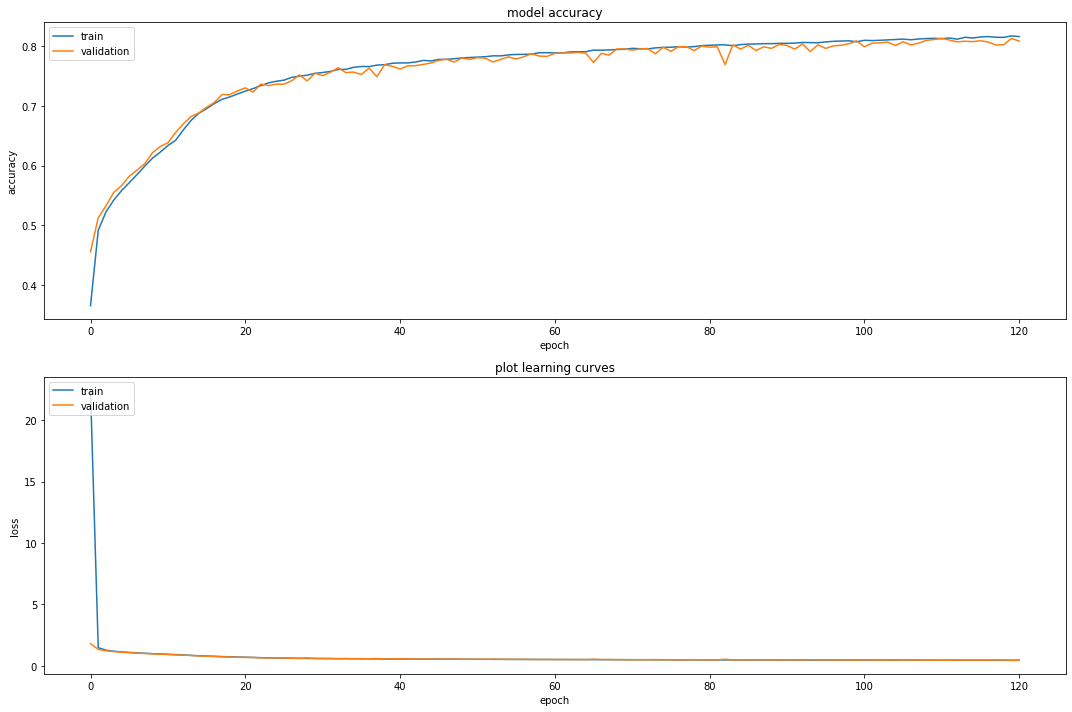

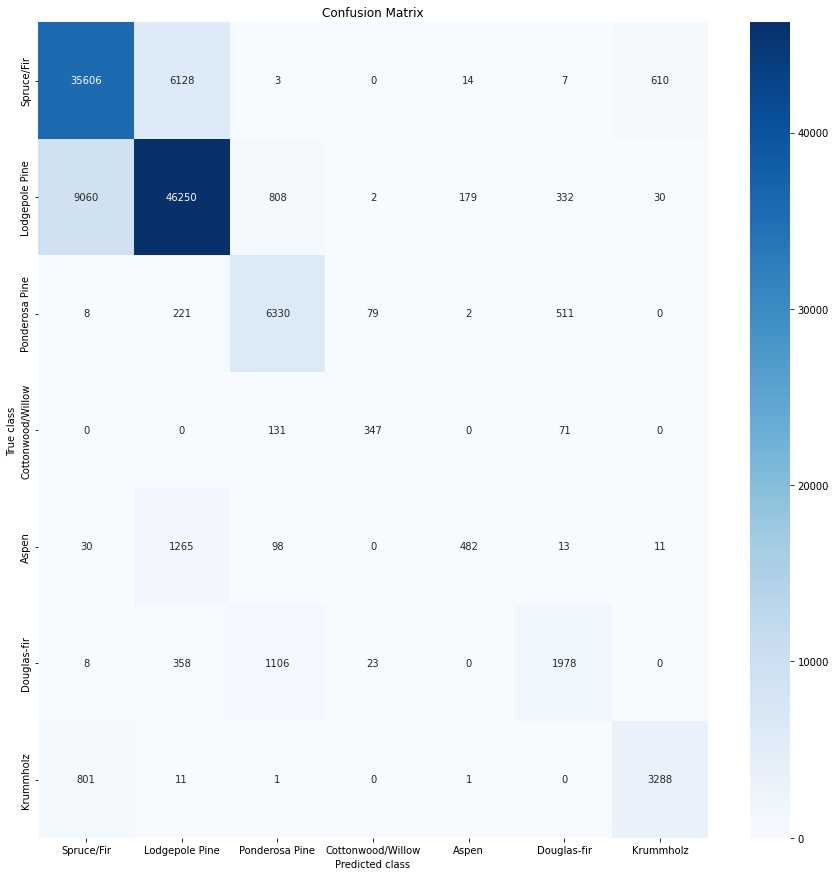

In [8]:

learning_rate = 0.00005
# Too many epochs can lead to overfitting, and too few to underfitting. 
num_epochs = 200
batch_size = 1024

history, features_test, labels_test = fit_model(learning_rate, num_epochs, batch_size)
#pprint.pprint(history.__dict__)
#pprint.pprint(history.model.__dict__)

plot_accuracy(history)

y_pred = report(history.model, features_test, labels_test)

plot_heatmap(class_names, y_pred, labels_test)